In [1]:
# import libraries
#import torch

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [4]:
"""Load from /home/USER/data/mnist or elsewhere; download if missing."""

import gzip
import os
from urllib.request import urlretrieve
import numpy as np
from matplotlib import image

def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    """
    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\salt
        path = os.path.join(os.path.expanduser('~/'), 'data', 'salt')

    # Create path if it doesn't exist
    #os.makedirs(path, exist_ok=True)
    """"
    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))
    print("All files are ready to gzip!")
    """
    def _images(path):
        """Return images loaded locally."""
        folder = path + "/images/"
        onlyfiles = [cv2.resize(cv2.cvtColor(image.imread(folder+f), cv2.COLOR_RGB2GRAY),(128, 128)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,128,128).astype('float32')#/255
        return pixels[:1,:,:,:]

    def _labels(path):
        """Return labels loaded locally."""
        
        folder = path + "/labels/"
        onlyfiles = [cv2.resize(image.imread(folder+f),(128, 128)) for f in os.listdir(folder)]
        pixels = np.array(onlyfiles).reshape(-1,1,128,128).astype('float32') #/255
        return pixels[:1,:,:,:]
    print("Train Images : Loading . . .")
    train_images = _images(path)
    print("Train Labels : Loading . . .")
    train_labels = _labels(path)
    """"
    print("Test Images  : Loading . . .")
    test_images = _images(os.path.join(path, files[2]))
    print("Test Labels  : Loading . . .")
    test_labels = _labels(os.path.join(path, files[3])) 
    """
    print("Done!")
    return train_images , train_labels #, test_images, test_labels

In [5]:
train_images, train_labels= mnist()  #, test_images, test_labels 

Train Images : Loading . . .
Train Labels : Loading . . .
Done!


In [6]:
ch = 1 #Number of channels
print(train_images.shape)
print(train_labels.shape) # ONE-HOT !!!
#print(train_images.T.shape)
#print(train_labels.reshape((train_images.shape[0], 10)).shape)

##### Getting Ready for the Conv Layers #####
#train_images = train_images.reshape(train_images.shape[0], ch, 28, 28).squeeze()
#test_images = test_images.reshape(test_images.shape[0], ch, 28, 28).squeeze()

#############################################

#y = train_images[1].reshape(1,28,28)
#print(y.squeeze().shape)
'''
temp = []
#train_labels = train_labels.sum(1)
for i in range(int(len(train_labels[:]))):
    temp.append(list(train_labels[i][:]).index(1))
    
    
train_labels = np.array(temp.copy())
#print(train_labels[0:5])
'''
#plt.imshow(train_images[0].squeeze(), cmap='Greys_r');
pass

(1, 1, 128, 128)
(1, 1, 128, 128)


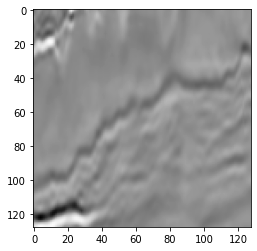

In [7]:
plt.imshow(train_images[0].squeeze(), cmap='Greys_r');


In [8]:
########### Convolution Architecture - Downsampling/Upsampling  ##################

def init_filters(layers, init_n_f ):
    filters = []
    bias = []
    f_dc = []
    trim = 0.1
    n_f = init_n_f #initial number of filters/kernels
    ch_in = 1      #input channels
    for i in range(layers):
        if(i != 0):
            n_f = n_f*2 #16,32,64,128,256
        #f1 shape : (num_filters,input channels, f_h, f_w)
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.randn(n_f, ch_in, 3, 3) *trim
        b1 = np.random.randn(f1.shape[0],1)* trim
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.randn(n_f, ch_in, 3, 3) *trim
        b2 = np.random.randn(f2.shape[0],1)* trim
        f = [f1, f2]
        b = [b1, b2]
        filters.append(f)
        bias.append(b)
    
    #Deconvolution filters    
    for i in range(1,layers):
        n_f = n_f//2 #128,64,32,16
        #f1 shape : (num_filters,input channels, f_h, f_w)
        fdc = np.random.randn(n_f,ch_in,2,2)*trim #upsampling filter, its result will be conc with conv4 output so the channels will be doubled again
        bdc = np.random.randn(fdc.shape[0],1)* trim
        f1 = (n_f, ch_in, 3, 3)
        f1 = np.random.randn(n_f, ch_in, 3, 3) *trim
        b1 = np.random.randn(f1.shape[0],1)* trim
        ch_in = n_f
        f2 = (n_f, ch_in, 3, 3)
        f2 = np.random.randn(n_f, ch_in, 3, 3) *trim
        b2 = np.random.randn(f2.shape[0],1)* trim
        f = [f1, f2]
        b = [b1, b2]
        dc = [fdc, bdc]
        filters.append(f)
        bias.append(b)
        f_dc.append(dc)
        
    
    return filters, bias, f_dc    

In [9]:
### Activation Functions ###
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [10]:
########## UTILITIES #############


def conv(image, params, s = 1, pad = 1 ): # s = 1 (conv stride)
    #f1 shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)
    [f, b] = params
    if(pad >= 1):
        tmp = np.zeros((image.shape[0],image.shape[1]+2*pad ,image.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = image
        image = tmp    
        
    f_num = f.shape[0]
    f_depth = f.shape[1] #f1 = 1 , f2 = 8
    f_size = f.shape[2] 
        
    
    h_range = int((image.shape[1] - f_size) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f_size) / s) + 1     # (W - F + 2P) / S  
    np_o = np.zeros((f_num, h_range, w_range))
    for z in range(f_num): # Number of filters
        for _h in range(h_range):      
            for _w in range(w_range):
                np_o[z, _h, _w] = np.sum(image[:, _h*s : _h*s + f_size, _w*s : _w*s + f_size] * f[z, :, :, :]) + b[z]
    
    return np_o

def convolutionBackward(dconv_prev, conv_in, filt, s = 1, pad = 1 ):
    f_num, n_c, f, _ = filt.shape
    
    _ ,h , w = dconv_prev.shape
    dfilt = np.zeros(filt.shape)
    if(pad >= 1):
        tmp = np.zeros((conv_in.shape[0],conv_in.shape[1]+2*pad ,conv_in.shape[2]+2*pad))
        tmp[:,pad:-pad,pad:-pad] = conv_in
        conv_in = tmp
    
    dconv_in = np.zeros(conv_in.shape)
    db = np.zeros((f_num,1))

    for z in range(f_num): # Number of filters
        for _h in range(h):      
            for _w in range(w):
                #each entry of the dconv_prev will try to affect the idxs from which was made of.
                dfilt[z] += dconv_prev[z, _h, _w] * conv_in[:, _h*s : _h*s + f, _w*s : _w*s + f]
                dconv_in[:, _h*s : _h*s + f, _w*s : _w*s + f] += dconv_prev[z, _h, _w] * filt[z]  
        db[z] = np.sum(dconv_prev[z])  #, axis =1) ## AXIS?
    
    if(pad >=1 ):
        dconv_in = dconv_in[:, pad:-pad, pad:-pad]  # Cropping
        
    return dconv_in, dfilt, db


def convTransp(image, params, s = 1, pad = 1):
    #s is always 1, upsample kernel = 2
    #zero insertions between pixels s_downsampled -1 = 2-1 = 1
    #required padding in order to double my dimensions with the given data:
    #(i-1)*2 + k -2p = output size, where our padding is k - p -1 = 2-0-1=1(we assume p=0)
    input_s = image.shape[1]
    target_dim = input_s*2 #final dim, after conv
    required_pad = 1 #always for filter 2x2 ,stride 1, zero insertion 1 and main target to double dim
    #make our new custom input
    size = input_s*2 +1
    new_in = np.zeros((image.shape[0], size, size))
    for i in range(1, target_dim, 2):
        for j in range(1, target_dim, 2):
                new_in[:, i, j] = image[:, i//2, j//2]
    #now we do a normal convolution(pad = 0)
    res = conv(new_in, params, 1, 0) #thats the final result with target_dim
    return res, new_in # we will need new_in so we wont calc it again for the backprop
    
def convTranspBackward(dconv_prev, new_in, filt, s = 1):
    #First, we do a backward convolution on new_in,d_conv_prev,
    #then we will choose form the d_conv_new the entries that match the initial 'smaller' input image
    #by selecting the odd matrix cells 1,3,5... because we had applied a standard pad=1,zero inser=1
    dconv_in, dfilt, db = convolutionBackward(dconv_prev, new_in, filt,1,0)
    #Now its time to choose the right entries to build the gradients of the initial input image
    dim = dconv_in.shape[1]
    final_dim = (new_in.shape[1] - 2)//2 + 1 #based on dimen of image before final conv that gives the result,..
    #e.g. for new_in 7x7 that is going to convoluted with a 2x2 kernel and give a 6x6 upsampled from 3x3 init image
    # now from this 7x7 --> apply the formula above,we get the 3x3 dimension number
    res = np.zeros((dconv_in.shape[0], final_dim, final_dim))
    for i in range(1, dim, 2):
        for j in range(1, dim, 2):
                res[:, i//2, j//2] = dconv_in[:, i, j]
    return res, dfilt, db
    
    
def maxpool(image, f=2 , s=2):
    
    h_range = int((image.shape[1] - f) / s) + 1     # (W - F + 2P) / S  
    w_range = int((image.shape[2] - f) / s) + 1     # (W - F + 2P) / S 
    out = np.zeros((image.shape[0], h_range, w_range))
    
    for z in range(image.shape[0]): # Number of channels
        for _h in range(h_range):      
            for _w in range(w_range):
                out[z, _h, _w] = np.max(image[z, _h*s : _h*s + f, _w*s : _w*s + f])
    return out

def nanargmax(arr):
    #print(arr.shape)
    try:
        idx = np.nanargmax(arr)
        #print (idx)
    except:
        idx = 0
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, conv, f=2 , s=2):
    num_c, h, w = conv.shape
    h = int((h - f) / s) + 1     # (W - F + 2P) / S  
    w = int((w - f) / s) + 1     # (W - F + 2P) / S 
    
    dout = np.zeros(conv.shape)
    #print(conv.shape)
    for z in range(num_c): # Number of channels
        for _h in range(h):      
            for _w in range(w):
                (a, b) = nanargmax(conv[z, _h*s : _h*s + f, _w*s : _w*s + f]) #Getting the indexes from the max value in this area
                #put it on the new array
                dout[z, _h + a, _w + b] = dpool[z, _h, _w]
    
    
    return dout


def reshape(img, reshape_dim):
    pad = reshape_dim - img.shape[1]
    if(pad == 0):
        return img
    res = np.zeros((img.shape[0], reshape_dim, reshape_dim))
    if(pad > 1):
        res[:, pad//2:-(pad//2), pad//2:-(pad//2)] = img
    else:
        res[:, 0:-(pad), 0:-(pad)] = img
    return res


def crop(img, crop_dim): #TODO : look at it..future upgrade to downsample..maybe
    start = img.shape[1]//2 - crop_dim//2
    return img[:,(start):(start +crop_dim),(start):(start +crop_dim)]

    
    
def crop2half(img):
    #return gradients for decoder side and gradients for encoder side
    n_ch = img.shape[0]//2
    return img[n_ch:n_ch*2 ,:,:], img[0:n_ch,:,:]
    
def concat(img1_true, img2):
    n_ch = img1_true.shape[0]
    dim = img1_true.shape[1]
    if(img2.shape[1] != dim):
        img2 = crop(img2, dim)
        print("Warning: Extra crop needed and handled!(%d --> %d)" %(dim, img2.shape[1]))
    res = np.zeros((n_ch*2, dim, dim))
    res[0:n_ch,:,:] = img2
    res[n_ch:n_ch*2 ,:,:] = img1_true
    return res



In [11]:
###### Cost Calculations ######
def NLLLoss(logs, targets):
    out = np.zeros(logs.shape)
    mylen = logs.shape[0]*logs.shape[1]*logs.shape[1]
    #print(len(targets))
    #logs.shape (dim x dim) like target
    for i in range(logs.shape[1]):
        for j in range(logs.shape[2]):
            if(targets[:,i,j] == 1):
                out[:,i,j] = logs[:,i,j] #in that case the propab. is correct with targen being the 1
            else:
                out[:,i,j] = 1 - logs[:,i,j] # e.g if logs[i,j]= 0.4 and we want(target) 0 --> 1-0.4=0.6 prob. for zero 
    #or
    #out = targets*logs + ((-1*(targets-1)) - (-1*(targets-1))*logs)
    return -np.log(out.sum()/mylen)

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost) ### ATTENTION!


###### Accuracy Calculation ######

# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [14]:
######  TRAIN  ######
#import torch
import time
time.time()


def train(X, Y, epochs, learning_rate, dropout, verbose=True, callback=None):
    # initiation of neural net parameters
    #params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    
    #f1,f2,f3,f4,f5,fd1,fd2,fd3,fd4
    filters,bias, f_dc = init_filters(5,16) #Double the channel-filter 4 times  (up to 256 and back again)
    ##Final 1x1 filter
    out_f = np.random.randn(1,16,1,1)*0.1
    out_b = np.random.randn(out_f.shape[0],1)*0.1   
    out_fb = [out_f, out_b]
    #filter shape : (num_filters,input channels, f_h, f_w)
    #image shape: (channels, height, width)

    v_adam =  [] #filter1,filter2
    s_adam =  [] 
    bv_adam = [] #bias1,bias2
    bs_adam = []
    fdc_v_adam=[] #filter,bias
    fdc_s_adam=[]
    #format: [v1,v2,v3,v4,v5,vd1,vd2,vd3,vd4] ,same for the rest, each of these include a tuple for the 2 conv filter
    #[s1,s2,s3,s4,s5,sd1,sd2,vs3,sd4]
    # upsampling filters : [v1_dc,v2_dc,v3_dc]  

            

    # performing calculations for subsequent iterations
    
    
    [f1,f2,f3,f4,f5,f6,f7,f8,f9] = filters
    [b1,b2,b3,b4,b5,b6,b7,b8,b9]= bias 
    [fb6_dc, fb7_dc, fb8_dc, fb9_dc] = f_dc
    
    
    for e in range(epochs):
        # step forward
        running_loss = 0
        accuracy = 0
        batch = 1
        print("Epoch: {%d}" %(e+1))
        for c in range(0, X.shape[0], batch):
            print('Batch: {}'.format(int(c/batch +1)))
            #### Reset Gradients (Every batch) ####
            beta1= 0.95
            beta2= 0.99
            lr = learning_rate
            batch_size= batch
            if(X.shape[0] - c < batch):#means that there is a smaller(<32) part left
                batch = X.shape[0] - c
            X_t = X[c:(c + batch)]  # shape:(m, ch, h, w)
            Y_t = Y[c:(c + batch)]
            cost = 0
            accuracy = 0
            
            df =  []
            db =  []
            dfb=  []
            for i in filters:
                v1 = np.zeros(i[0].shape)
                v2 = np.zeros(i[1].shape)
                s1 = np.zeros(i[0].shape)
                s2 = np.zeros(i[1].shape)
                v_a = [v1, v2]
                s_a = [s1, s2]
                v_adam.append(v_a)
                s_adam.append(s_a)
                
                df1_t = np.zeros(i[0].shape)
                df2_t = np.zeros(i[1].shape)
                f_temp = [df1_t, df2_t]
                df.append(f_temp)
                
            for i in bias:
                bv1 = np.zeros(i[0].shape)
                bv2 = np.zeros(i[1].shape)
                bs1 = np.zeros(i[0].shape)
                bs2 = np.zeros(i[1].shape)    
                bv_a = [bv1, bv2]
                bs_a = [bs1, bs2]
                bv_adam.append(bv_a)
                bs_adam.append(bs_a)
                
                
                db1_t = np.zeros(i[0].shape)
                db2_t = np.zeros(i[1].shape)
                b_temp = [db1_t, db2_t]
                db.append(b_temp)
            
            for i in f_dc:
                fdc_v1 = np.zeros(i[0].shape)
                bdc_v2 = np.zeros(i[1].shape)
                fdc_s1 = np.zeros(i[0].shape)
                bdc_s2 = np.zeros(i[1].shape)    
                fdc_v_a = [fdc_v1, bdc_v2]
                fdc_s_a = [fdc_s1, bdc_s2]
                fdc_v_adam.append(fdc_v_a)
                fdc_s_adam.append(fdc_s_a)
                
                
                df1_t = np.zeros(i[0].shape)
                db1_t = np.zeros(i[1].shape)
                fb_temp = [df1_t, db1_t]
                dfb.append(fb_temp)
            
            
            #Final layer 1x1 filter setup

            v_out_f = np.zeros(out_f.shape)
            s_out_f = np.zeros(out_f.shape)
            bv_out_b = np.zeros(out_b.shape)
            bs_out_b = np.zeros(out_b.shape)
            
            
            
            dout_f = np.zeros(out_f.shape)
            dout_b = np.zeros(out_b.shape)
            
            ######################################
            
            
            #timestamp1 = time.time()
            
            
            [df1,df2,df3,df4,df5,df6,df7,df8,df9] = df
            [db1,db2,db3,db4,db5,db6,db7,db8,db9] = db 
            [dfb6_dc,dfb7_dc,dfb8_dc,dfb9_dc]     = dfb
            
            
            for b in range(batch):
                
                print('Image: {}/{}'.format((b+1),batch))
                #################### TODO: BLOCK IMPLEMENTATION - FUTURE UPDATE ######################
                    
                    
                #########################################################################################
                #########################################################################################
                ######################## Forward Propagation Convolution Part  ##########################

                
                ########### 1st Big Layer ###########    (with zero padding ='same',so with stride =1 we get same dim as the input)
                params = [f1[0], b1[0]]  
                conv1_1 = conv(X_t[b], params, 1)   #conv1 shape = (num_channels, h, w), padding = 1 (same output dim)
                conv1_1[conv1_1<=0] = 0 #Relu

                params = [f1[1], b1[1]]
                conv1_2 = conv(conv1_1, params, 1)
                conv1_2[conv1_2<=0] = 0 #Relu
                ##################################### conv1_2: 128x128x16
                
                pl1 = maxpool(conv1_2, 2, 2) #   pl1 : (128-2)/2+1  = 64 
                ## ADD DROPOUT HERE(on pl1)
                
                ########### 2nd Big Layer ###########
                params = [f2[0], b2[0]]  
                conv2_1 = conv(pl1, params, 1)   #conv1 shape = (num_channels, h, w)
                conv2_1[conv2_1<=0] = 0 #Relu

                params = [f2[1], b2[1]]
                conv2_2 = conv(conv2_1, params, 1)
                conv2_2[conv2_2<=0] = 0 #Relu             
                #####################################  64x64x32

                pl2 = maxpool(conv2_2, 2, 2) #pool_f = 2 , pool_s = 2    , (64 -2)/2 +1 = 32
                ## ADD DROPOUT HERE

                ########### 3rd Big Layer ###########
                params = [f3[0], b3[0]]  
                conv3_1 = conv(pl2, params, 1)   #conv1 shape = (num_channels, h, w)
                conv3_1[conv3_1<=0] = 0 #Relu

                params = [f3[1], b3[1]]
                conv3_2 = conv(conv3_1, params, 1)
                conv3_2[conv3_2<=0] = 0 #Relu             
                #####################################  32x32x64

                pl3 = maxpool(conv3_2, 2, 2) #pool_f = 2 , pool_s = 2   ,  (32-2)/2 +1 = 16
                ## ADD DROPOUT HERE
                
                ########### 4th Big Layer ###########
                params = [f4[0], b4[0]]  
                conv4_1 = conv(pl3, params, 1)   #conv1 shape = (num_channels, h, w)
                conv4_1[conv4_1<=0] = 0 #Relu

                params = [f4[1], b4[1]]
                conv4_2 = conv(conv4_1, params, 1)
                conv4_2[conv4_2<=0] = 0 #Relu             
                #####################################     16x16x128

                pl4 = maxpool(conv4_2, 2, 2) #pool_f = 2 , pool_s = 2  , (16-2)/2 +1 =8  : 8x8x128
                ## ADD DROPOUT HERE
                
                ########### 5th Big Layer ###########   8x8x128-->8x8x256
                params = [f5[0], b5[0]]  
                conv5_1 = conv(pl4, params, 1)   #conv1 shape = (num_channels, h, w)
                conv5_1[conv5_1<=0] = 0 #Relu

                params = [f5[1], b5[1]]
                conv5_2 = conv(conv5_1, params, 1)
                conv5_2[conv5_2<=0] = 0 #Relu             
                #####################################  8x8x256
                
                #####################################
                #Because of ambigious size after the upsampling the concat func must take care possible crop of the conv#_2 
                #####################################
                #Deconvolution/Upsampling
                # insert zeros : s-1 = 1, padding = k - p -1 = 2-0(what i want)-1=1 ,  s'=1(always) --> (i-1)*s+k-2p = 
                params = [fb6_dc[0], fb6_dc[1]] # deconv filter, deconv bias
                dc6, new_in6 = convTransp(conv5_2, params, 1, 0)   #result:   =  16x16x128 , # conv5_2 requires NO crop
                #Concat dc6 with conv4_2 so we get 256 channels (16x16x256)
                c6 = concat(dc6, conv4_2) # 1st one is the right one size  
                
                ########### 1st Big dc Layer ###########          16x16x256     
                params = [f6[0], b6[0]]  
                conv6_1 = conv(c6, params, 1)   #conv1 shape = (num_channels, h, w)
                conv6_1[conv6_1<=0] = 0 #Relu

                params = [f6[1], b6[1]]
                conv6_2 = conv(conv6_1, params, 1)
                conv6_2[conv6_2<=0] = 0 #Relu   
                #####################################    16x16x128
                #(16-1)*2 + 2 =32
                params = [fb7_dc[0], fb7_dc[1]] # deconv filter, deconv bias
                dc7, new_in7 = convTransp(conv6_2, params, 1, 0)   #result:   =  32x32x64
                #Concat dc7 with conv3_2 so we get  channels (32x32x128)
                c7 = concat(dc7, conv3_2)   
                
                ########### 2nd Big dc Layer ###########          32x32x128     
                params = [f7[0], b7[0]]  
                conv7_1 = conv(c7, params, 1)   #conv1 shape = (num_channels, h, w)
                conv7_1[conv7_1<=0] = 0 #Relu

                params = [f7[1], b7[1]]
                conv7_2 = conv(conv7_1, params, 1)
                conv7_2[conv7_2<=0] = 0 #Relu     
                #####################################    32x32x64
                #(24-1)*2 + 2 = 48
                params = [fb8_dc[0], fb8_dc[1]] # deconv filter, deconv bias
                dc8, new_in8 = convTransp(conv7_2, params, 1, 0)   #result:   =  64x64x32
                #Concat dc8 with conv2_2 so we get  channels (64x64x64)
                c8 = concat(dc8 ,conv2_2)   
                
                ########### 3rd Big dc Layer ###########          64x64x64    
                params = [f8[0], b8[0]]  
                conv8_1 = conv(c8, params, 1)   #conv1 shape = (num_channels, h, w)
                conv8_1[conv8_1<=0] = 0 #Relu

                params = [f8[1], b8[1]]
                conv8_2 = conv(conv8_1, params, 1)
                conv8_2[conv8_2<=0] = 0 #Relu    
                #####################################    64x64x32                              
                #(64-1)*2 + 2 = 128
                params = [fb9_dc[0], fb9_dc[1]] # deconv filter, deconv bias
                dc9, new_in9 = convTransp(conv8_2, params, 1, 0)   #result:   =  128x128x16
                #Concat dc9 with conv1_2 so we get  channels (128x128x32)
                c9 = concat(dc9, conv1_2)                   
               
                ########### 4th Big dc Layer ###########          128x128x32   
                params = [f9[0], b9[0]]  
                conv9_1 = conv(c9, params, 1)   #conv1 shape = (num_channels, h, w)
                conv9_1[conv9_1<=0] = 0 #Relu

                params = [f9[1], b9[1]]
                conv9_2 = conv(conv9_1, params, 1)
                conv9_2[conv9_2<=0] = 0 #Relu   
                #####################################    128x128x16
                
                ############################# Last Layer conv(1x1) --> 128x128x1 ##########################
                params = [out_f, out_b]
                output = conv(conv9_2, params, 1, 0) #output.shape: 128x128x1
                
                print(output[:,0:30,0:30])
                ## Sigmoid ##
                Y_hat = sigmoid(output)
                
                #label crop is needed
                #Y_t_b = crop(Y_t[b], Y_hat.shape[1])
                plt.imshow(Y_hat.squeeze(), cmap='Greys_r');
                cost += NLLLoss(Y_hat, Y_t[b])
                print(cost/(b+1))
                
                accuracy += get_accuracy_value(Y_hat, Y_t[b])
                print(accuracy/(b+1))
                #########################################################################################
                #########################################################################################
                ################################# Backward Propagation ##################################
                
                
                #Pixel-wise sub, we we can get the diff(Y includes the 2 classes 0 and 1)
                
                dA_prev = Y_hat - Y_t[b]
                dZ_prev = sigmoid_backward(dA_prev, output)
                conv_s =1 
                dconv9_2, dout_f_, dout_b_ = convolutionBackward(dZ_prev, conv9_2, out_f, conv_s) #
                #pack data
                
                
                dconv9_2[conv9_2<=0] = 0             
                dconv9_1, df9_2, db9_2 = convolutionBackward(dconv9_2, conv9_1, f9[1], conv_s) #
                #pack data
                dconv9_1[conv9_1<=0] = 0
                conc_dconv9, df9_1, db9_1 = convolutionBackward(dconv9_1, c9, f9[0], conv_s) #C9 is not needed for input,we know how to select the right gradients
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv9, dconv1_2 = crop2half(conc_dconv9)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #conv8_2 is not needed for input,we know how to select the right gradients            
                #dconv1_2 = reshape(dconv1_2, conv1_2.shape[1])
                
                dconv8_2, df9_dc, db9_dc = convTranspBackward(dconv9, new_in9, fb9_dc[0],conv_s)
                #pack data

                dconv8_2[conv8_2<=0] = 0
                dconv8_1, df8_2, db8_2 = convolutionBackward(dconv8_2, conv8_1, f8[1], conv_s) #
                #pack data
                dconv8_1[conv8_1<=0] = 0
                conc_dconv8, df8_1, db8_1 = convolutionBackward(dconv8_1, c8, f8[0], conv_s) #
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv8, dconv2_2 = crop2half(conc_dconv8)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #dconv2_2 = reshape(dconv2_2, conv2_2.shape[1])
                
                dconv7_2, df8_dc, db8_dc = convTranspBackward(dconv8, new_in8, fb8_dc[0],conv_s)
                #pack data
                
                dconv7_2[conv7_2<=0] = 0
                dconv7_1, df7_2, db7_2 = convolutionBackward(dconv7_2, conv7_1, f7[1], conv_s) #
                #pack data
                dconv7_1[conv7_1<=0] = 0
                conc_dconv7, df7_1, db7_1 = convolutionBackward(dconv7_1, c7, f7[0], conv_s) #
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv7, dconv3_2 = crop2half(conc_dconv7)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #Make sure that dconv3_2 is the same dim with the dconv3_2 that will come from maxpool in decoding side
                #dconv3_2 = reshape(dconv3_2, conv3_2.shape[1])
                
                dconv6_2, df7_dc, db7_dc = convTranspBackward(dconv7, new_in7, fb7_dc[0],conv_s)
                #pack data
                
                dconv6_2[conv6_2<=0] = 0
                dconv6_1, df6_2, db6_2 = convolutionBackward(dconv6_2, conv6_1, f6[1], conv_s) #
                #pack data
                dconv7_1[conv7_1<=0] = 0
                conc_dconv6, df6_1, db6_1 = convolutionBackward(dconv6_1, c6, f6[0], conv_s) #
                
                ###### we get the concat gradients ######
                #crop the half matrix, we need the second half with the gradients(according to the concat thats the output of the transposed conv)
                #### we split the gradients and push them back to their sources  ####
                dconv6, dconv4_2 = crop2half(conc_dconv6)  #we will later add gradients of dconv1_2(came from backprop concat) with the extra gradients of its next layer
                #dconv4_2 = reshape(dconv4_2, conv4_2.shape[1])
                
                dconv5_2, df6_dc, db6_dc = convTranspBackward(dconv6, new_in6, fb6_dc[0],conv_s)
                #pack data
                
                dconv5_2[conv5_2<=0] = 0
                dconv5_1, df5_2, db5_2 = convolutionBackward(dconv5_2, conv5_1, f5[1], conv_s) #
                #pack data
                dconv5_1[conv5_1<=0] = 0
                dpl4, df5_1, db5_1 = convolutionBackward(dconv5_1, pl4, f5[0], conv_s) #
                
                dconv4_2 += maxpoolBackward(dpl4, conv4_2, f=2 , s=2) #Very important += merge with the gradients from concat backprop
                
                dconv4_2[conv4_2<=0] = 0
                dconv4_1, df4_2, db4_2 = convolutionBackward(dconv4_2, conv4_1, f4[1], conv_s) #
                #pack data
                dconv4_1[conv4_1<=0] = 0
                dpl3, df4_1, db4_1 = convolutionBackward(dconv4_1, pl3, f4[0], conv_s) #

                dconv3_2 += maxpoolBackward(dpl3, conv3_2, f=2 , s=2)#Very important += merge with the gradients from concat backprop
                
                dconv3_2[conv3_2<=0] = 0
                dconv3_1, df3_2, db3_2 = convolutionBackward(dconv3_2, conv3_1, f3[1], conv_s) #
                #pack data
                dconv3_1[conv3_1<=0] = 0
                dpl2, df3_1, db3_1 = convolutionBackward(dconv3_1, pl2, f3[0], conv_s) #
                
                dconv2_2 += maxpoolBackward(dpl2, conv2_2, f=2 , s=2)#Very important += merge with the gradients from concat backprop
                
                dconv2_2[conv2_2<=0] = 0
                dconv2_1, df2_2, db2_2 = convolutionBackward(dconv2_2, conv2_1, f2[1], conv_s) #
                #pack data
                dconv2_1[conv2_1<=0] = 0
                dpl1, df2_1, db2_1 = convolutionBackward(dconv2_1, pl1, f2[0], conv_s) #
                
                dconv1_2 += maxpoolBackward(dpl1, conv1_2, f=2 , s=2)#Very important += merge with the gradients from concat backprop
                
                dconv1_2[conv1_2<=0] = 0
                dconv1_1, df1_2, db1_2 = convolutionBackward(dconv1_2, conv1_1, f1[1], conv_s) #
                #pack data
                dconv1_1[conv1_1<=0] = 0
                _, df1_1, db1_1 = convolutionBackward(dconv1_1, X_t[b], f1[0], conv_s) #
                
                
                
                
                

                [df1,df2,df3,df4,df5,df6,df7,df8,df9] = df
                [db1,db2,db3,db4,db5,db6,db7,db8,db9] = db 
                [dfb6_dc,dfb7_dc,dfb8_dc,dfb9_dc]     = dfb

                
                df1[0] += df1_1
                df1[1] += df1_2
                df2[0] += df2_1
                df2[1] += df2_2
                df3[0] += df3_1
                df3[1] += df3_2
                df4[0] += df4_1
                df4[1] += df4_2
                df5[0] += df5_1
                df5[1] += df5_2
                df6[0] += df6_1
                df6[1] += df6_2
                df7[0] += df7_1
                df7[1] += df7_2
                df8[0] += df8_1
                df8[1] += df8_2
                df9[0] += df9_1
                df9[1] += df9_2
                
                db1[0] += db1_1
                db1[1] += db1_2
                db2[0] += db2_1
                db2[1] += db2_2
                db3[0] += db3_1
                db3[1] += db3_2
                db4[0] += db4_1
                db4[1] += db4_2
                db5[0] += db5_1
                db5[1] += db5_2
                db6[0] += db6_1
                db6[1] += db6_2
                db7[0] += db7_1
                db7[1] += db7_2
                db8[0] += db8_1
                db8[1] += db8_2
                db9[0] += db9_1
                db9[1] += db9_2

                dfb6_dc[0] += df6_dc
                dfb6_dc[1] += db6_dc
                dfb7_dc[0] += df7_dc
                dfb7_dc[1] += db7_dc
                dfb8_dc[0] += df8_dc
                dfb8_dc[1] += db8_dc
                dfb9_dc[0] += df9_dc
                dfb9_dc[1] += db9_dc

                dout_f += dout_f_
                dout_b += dout_b_
            
            
            
            
            ############## Adam Optimization ################
            #changing the main structures(which are also updated)
            #TODO: Future update - remove uneccessary memory loads/stores, v,s dont need to be saved 
            for i in range(len(filters)):
                v_adam[i][0] = beta1*v_adam[i][0] + (1-beta1)*df[i][0]/batch_size #f1
                s_adam[i][0] = beta2*s_adam[i][0] + (1-beta2)*(df[i][0]/batch_size)**2 #f1
                filters[i][0] -= lr*v_adam[i][0]/np.sqrt(s_adam[i][0] + 1e-7)
                
                v_adam[i][1] = beta1*v_adam[i][1] + (1-beta1)*df[i][1]/batch_size #f2
                s_adam[i][1] = beta2*s_adam[i][1] + (1-beta2)*(df[i][1]/batch_size)**2  #f2
                filters[i][1] -= lr*v_adam[i][1]/np.sqrt(s_adam[i][1] + 1e-7)
                
            for i in range(len(bias)):
                bv_adam[i][0] = beta1*bv_adam[i][0] + (1-beta1)*db[i][0]/batch_size #b1
                bs_adam[i][0] = beta2*bs_adam[i][0] + (1-beta2)*(db[i][0]/batch_size)**2  #b1
                bias[i][0] -= lr*bv_adam[i][0]/np.sqrt(bs_adam[i][0] + 1e-7)
                
                bv_adam[i][1] = beta1*bv_adam[i][1] + (1-beta1)*db[i][1]/batch_size #b2
                bs_adam[i][1] = beta2*bs_adam[i][1] + (1-beta2)*(db[i][1]/batch_size)**2  #b2
                bias[i][1] -= lr*bv_adam[i][1]/np.sqrt(bs_adam[i][1] + 1e-7)
            
            for i in range(len(f_dc)):
                fdc_v_adam[i][0] = beta1*fdc_v_adam[i][0] + (1-beta1)*dfb[i][0]/batch_size #f1
                fdc_s_adam[i][0] = beta2*fdc_s_adam[i][0] + (1-beta2)*(dfb[i][0]/batch_size)**2  #f1
                f_dc[i][0] -= lr*fdc_v_adam[i][0]/np.sqrt(fdc_s_adam[i][0] + 1e-7)
                
                fdc_v_adam[i][1] = beta1*fdc_v_adam[i][1] + (1-beta1)*dfb[i][1]/batch_size #b2
                fdc_s_adam[i][1] = beta2*fdc_s_adam[i][1] + (1-beta2)*(dfb[i][1]/batch_size)**2  #b2
                f_dc[i][1] -= lr*fdc_v_adam[i][1]/np.sqrt(fdc_s_adam[i][1] + 1e-7)    
            
            v_out_f = beta1*v_out_f + (1 - beta1)*dout_f/batch_size #f
            s_out_f = beta2*s_out_f + (1 - beta2)*(dout_f/batch_size)**2  #f
            out_fb[0] -= lr*v_out_f/np.sqrt(s_out_f + 1e-7)
            
            bv_out_b = beta1*bv_out_b + (1 - beta1)*dout_b/batch_size #b
            bs_out_b = beta2*bs_out_b + (1 - beta2)*(dout_b/batch_size)**2  #b
            out_fb[1] -= lr*bv_out_b/np.sqrt(bs_out_b + 1e-7)
            
            
            #Updating Conv Part
            

            #print(Yh)
            #print(t)
            #print("Batch:{}".format(c+12))
            
            '''
            f1 -= (learning_rate) * (df1/batch)
            f2 -= (learning_rate) * (df2/batch)
            b1 -= (learning_rate) * (db1/batch)
            b2 -= (learning_rate) * (db2/batch)
            filter_params = [f1, f2, b1, b2]
                
            # updating FC Part
            #params_values = update(params_values, grads_values, nn_architecture, learning_rate)
            grads_values['dW1'] = dW1#/(batch)
            grads_values['dW2'] = dW2#/(batch)
            grads_values['db1'] = dB1#/(batch)
            grads_values['db2'] = dB2#/(batch)
                   
            for layer_idx, layer in enumerate(nn_architecture, 1):
                
                params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
                params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

            
            '''
            print("Cost : {:.5f}".format(cost/batch))
            print("Accuracy : {:.5f}%".format((accuracy*100)/batch))
            
        #END OF LOOP - EPOCH
        #timestamp2 = time.time()
        #print ("This took %.2f seconds" %(timestamp2 - timestamp1))
        if(verbose):
            print("Epoch: {:5d}   -   cost: {:.2f}   -   Accuracy: {:.2f}%".format(e+1, cost/batch, (accuracy*100)/batch))
        #if(callback is not None):
        #    callback(i, params_values)
    #pack filters
    params_values = [filters, bias, f_dc, out_fb]
    return params_values

Epoch: {1}
Batch: 1
Image: 1/1
[[[ 3.89362625e+00 -5.90875716e+00 -3.03553948e+00 -6.24244829e+00
    2.92696200e+00 -9.80881401e+00 -6.71580264e+00 -7.58433826e+00
   -5.25960443e+00 -1.04254032e+01  9.87024897e-01 -8.89167046e+00
   -5.46555375e+00 -9.94032643e+00 -4.35661431e+00 -1.05676747e+01
   -4.12945362e-01 -1.53179307e+01  4.49509390e+00 -5.77241895e+00
    2.51419909e+00 -7.46596526e+00 -7.13064072e+00 -9.57411985e+00
   -3.37338552e+00 -1.47577251e+01  2.23241404e+00 -6.07807437e+00
   -7.60284315e+00 -1.19489282e+01]
  [-6.48708343e+00 -2.33247158e+00 -6.51907903e+00  3.71650451e+00
   -1.25858181e+00 -1.65466123e+01  3.30757185e-02 -1.05713547e+01
    9.64224193e+00 -1.16168084e+01  2.49937917e+00 -4.20548397e+00
   -1.82230543e+00 -4.37699091e+00 -2.13324578e-01  9.70607970e-01
    2.75424073e+00 -2.44284971e+00 -7.59317025e+00 -1.93632817e-01
   -3.01382793e+00 -1.56766909e+01  7.89388730e+00 -1.37280927e+01
    5.51860116e+00 -1.51636360e+01  3.05683783e+00 -7.03879943

Cost : 0.64272
Accuracy : 51.10474%
Epoch:     1   -   cost: 0.64   -   Accuracy: 51.10%
Epoch: {2}
Batch: 1
Image: 1/1
[[[-6.35915104e+01 -7.80765443e+01 -1.52195912e+02 -1.04583770e+02
   -1.79449379e+02 -9.08630205e+01 -8.70495362e+01 -1.51828876e+02
   -2.02240552e+02 -2.11186707e+01 -2.56421972e+02 -1.15128067e+02
   -2.55493501e+02 -1.50035061e+02 -1.36085252e+02 -1.89279256e+02
   -2.58392675e+02 -9.16843253e+01 -1.46062765e+02  1.57101992e+01
   -2.36700450e+02 -1.68113299e+02 -1.28325344e+02 -1.98843272e+02
   -2.13309455e+02  1.12768156e+01 -3.43686814e+02 -1.09683016e+02
   -3.56098223e+02 -1.55022474e+02]
  [-1.80206532e+02 -1.95715441e+01 -1.48542230e+02  9.43848840e+01
   -1.84429378e+02  2.83249314e+01  6.85753864e+01  2.42557276e+02
   -3.43586092e+02  6.17975846e+00  6.32647568e+01  7.76933213e+01
   -2.33763167e+02  8.44410927e+01  1.58958382e+02  2.17406524e+02
   -3.87130297e+02 -1.94366366e+01  7.30435627e+01  1.84617585e+02
   -3.07790179e+02  1.77292616e+02  8.62

<ipython-input-9-450200030ae6>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-Z))


Cost : 0.57232
Accuracy : 54.49829%
Epoch:     2   -   cost: 0.57   -   Accuracy: 54.50%
Epoch: {3}
Batch: 1
Image: 1/1
[[[  148.99443306  -212.39357334   181.61300066  -162.99441289
     402.9311004   -148.17724905   564.37705303  -282.22329543
     634.0218962   -232.26730615   629.73452467  -341.02740789
     613.86848729  -365.85742428   749.17278018  -398.297308
     838.22861623  -329.26943379   950.32956135  -393.85315694
     733.23242422  -318.80512973  1018.9844793   -473.00115393
    1001.37951866  -328.72442596  1033.91174282  -480.40579583
     805.42696216  -520.03488135]
  [ -110.11380171   157.4210363    202.64127977   412.69915968
     154.03076143   617.79126446   350.57795364  1013.50668553
     176.75696162   722.34918337   438.74492424  1000.95505437
     271.05569636  1257.64845536   464.10326273  1389.59045134
     361.14919237   943.35715097   570.73561024  1329.09950588
     338.28027319  1344.61460377   430.27683799  1782.48329344
     260.46259027  1087.80541

Cost : 0.73944
Accuracy : 47.19849%
Epoch:     3   -   cost: 0.74   -   Accuracy: 47.20%
Epoch: {4}
Batch: 1
Image: 1/1
[[[ 1.73055225e+03 -8.00166960e+03  3.98918117e+03 -9.68326852e+03
    6.74532926e+03 -8.57368158e+03  9.49525037e+03 -1.41128249e+04
    1.14709808e+04 -1.59483043e+04  1.01052131e+04 -1.77206164e+04
    8.41421164e+03 -1.50999158e+04  1.18070637e+04 -1.97521136e+04
    1.39958854e+04 -2.18531358e+04  1.37180707e+04 -2.35843043e+04
    1.01622686e+04 -1.53716470e+04  1.40682056e+04 -2.47929374e+04
    1.60868283e+04 -2.38464751e+04  1.26615711e+04 -2.54613221e+04
    1.00576419e+04 -1.88210398e+04]
  [-3.50408247e+03  5.77967750e+03  3.22500485e+02  7.41587442e+03
   -4.46172847e+03  8.03068132e+03  4.47028377e+03  1.59352885e+04
   -3.90249924e+03  1.08743910e+04  5.44097626e+03  1.35629115e+04
   -5.43421747e+03  1.39597198e+04  4.09791324e+03  1.88008976e+04
   -5.28049933e+03  1.30319046e+04  6.80015677e+03  1.83019921e+04
   -6.34277234e+03  1.73827948e+04  5.16

Cost : 0.69620
Accuracy : 49.05396%
Epoch:     4   -   cost: 0.70   -   Accuracy: 49.05%
Epoch: {5}
Batch: 1
Image: 1/1
[[[ 2.70068704e+04 -1.95783306e+05  9.28198342e+04 -2.92866863e+05
    1.12483169e+05 -2.66425796e+05  1.78353234e+05 -3.85367261e+05
    1.85453535e+05 -3.79886789e+05  1.83527574e+05 -5.13591373e+05
    1.47814195e+05 -4.00820415e+05  2.22177800e+05 -5.49897346e+05
    2.28594451e+05 -5.22696002e+05  2.27328200e+05 -6.60866655e+05
    1.76618464e+05 -4.50487020e+05  2.57962769e+05 -6.57879700e+05
    2.60379522e+05 -5.80057960e+05  2.35474048e+05 -7.25552763e+05
    1.91891257e+05 -5.19674176e+05]
  [-7.51722252e+04  1.14107233e+05  4.50885224e+03  7.39904773e+04
   -1.68922555e+05  6.80890165e+04  9.59327710e+04  1.82119599e+05
   -1.72182862e+05  1.29158877e+05  1.35152105e+05  1.36381142e+05
   -2.31249929e+05  1.25239434e+05  1.10719726e+05  2.16907604e+05
   -2.28603828e+05  1.46607370e+05  1.61858120e+05  1.62702000e+05
   -2.95965007e+05  1.52766267e+05  1.33

KeyboardInterrupt: 

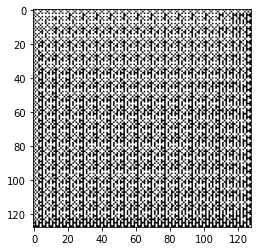

In [15]:
###### Training ######
#train_images, train_labels, test_images, test_labels
import gc
gc.collect()

params_values = train(train_images, train_labels, 10, 0.01, True) #0.05 stable LR

In [ ]:
###### Prediction ######
Yt = test_labels.T
temp1 = []
for i in range(Yt.shape[1]):
        for j in range(Yt.shape[0]):
            if(Yt[j][i]==1):
                temp1.append(j)
Yt=np.array(temp1)
Y_test_hat, _ = full_forward_propagation(np.transpose(test_images), params_values, NN_ARCHITECTURE)#multiple?!

Yht = np.array(Y_test_hat.T)
#x_log=np.log( np.exp(Yh) / np.sum(np.exp(Yh), axis = 1) )  #(60000,10) , we need to add along columns so we get sum of 1 on every example-row
num = np.exp(Yht)
den = np.sum(np.exp(Yht), axis = 1)
for i in range(Yht.shape[0]): #60000
                #for j in range(Yh.shape[1]): #10
                Yht[i][:] = np.log(num[i][:] / den[i])  

#cost = get_cost_value(Yht, Yt)

#cost_history.append(cost)
accuracy = get_accuracy_value(Y_test_hat, test_labels.T)
#accuracy_history.append(accuracy)
print("Accuracy: {:.5f}%".format( accuracy*100))